### DSE 220 Final: Random Forest Regressor Model for Amazon Review Helpfulness

## Kaggle Name: Loves2spooch

### Code
This section will display the code for our predictive Random Forest Regressor Model for Amazon Review Helpfulness.

In [ ]:
import xgboost as xgb
import random
from random import randint
from sklearn.model_selection import cross_val_predict, TimeSeriesSplit, KFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

In [391]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from six.moves import cPickle as pickle
import pandas as pd
import gzip
import seaborn as sns
import string
from time import time
import nltk
from nltk.corpus import stopwords 
#stops = set(stopwords.words("english"))

In [392]:
# Import the classifier
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap         # Visualization
import numpy as np                                   # Numerical operations
import matplotlib.pyplot as plt                      # Plotting
from sklearn.model_selection import train_test_split # Data splitting
import pandas as pd
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import itertools 
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import datasets, decomposition, feature_extraction
from sklearn.datasets import fetch_20newsgroups
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, chi2
from nltk.corpus import brown
import collections
import operator
import math
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.metrics.pairwise import cosine_similarity as cs
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from nltk.cluster import KMeansClusterer, euclidean_distance, cosine_distance
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import random
from random import randint
from sklearn.model_selection import cross_val_predict, TimeSeriesSplit, KFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

In [393]:
import gzip
from collections import defaultdict

## Helpfulness baseline 
### Compute the global average helpfulness rate, and the average helpfulness rate for each user

In [394]:
def readGz(f):
  for l in gzip.open(f):
    yield eval(l)

allHelpful = []
userHelpful = defaultdict(list)

for l in readGz("train.json.gz"):
  user,item = l['reviewerID'],l['itemID']
  allHelpful.append(l['helpful'])
  userHelpful[user].append(l['helpful'])

averageRate = sum([x['nHelpful'] for x in allHelpful]) * 1.0 / sum([x['outOf'] for x in allHelpful])
userRate = {}
for u in userHelpful:
  totalU = sum([x['outOf'] for x in userHelpful[u]])
  if totalU > 0:
    userRate[u] = sum([x['nHelpful'] for x in userHelpful[u]]) * 1.0 / totalU
  else:
    userRate[u] = averageRate

predictions = open("predictions_Helpful.txt", 'w')
for l in open("pairs_Helpful.txt"):
  if l.startswith("userID"):
    #header
    predictions.write(l)
    continue
  u,i,outOf = l.strip().split('-')
  outOf = int(outOf)
  if u in userRate:
    predictions.write(u + '-' + i + '-' + str(outOf) + ',' + str(outOf*userRate[u]) + '\n')
  else:
    predictions.write(u + '-' + i + '-' + str(outOf) + ',' + str(outOf*averageRate) + '\n')

predictions.close()

In [395]:
averageRate

0.8519720886532813

In [396]:
userHelpful

defaultdict(list,
            {'U745881038': [{'outOf': 0, 'nHelpful': 0},
              {'outOf': 0, 'nHelpful': 0},
              {'outOf': 0, 'nHelpful': 0},
              {'outOf': 2, 'nHelpful': 2}],
             'U023577405': [{'outOf': 0, 'nHelpful': 0},
              {'outOf': 6, 'nHelpful': 6},
              {'outOf': 1, 'nHelpful': 1},
              {'outOf': 1, 'nHelpful': 1},
              {'outOf': 0, 'nHelpful': 0},
              {'outOf': 0, 'nHelpful': 0}],
             'U441384838': [{'outOf': 2, 'nHelpful': 2},
              {'outOf': 0, 'nHelpful': 0},
              {'outOf': 5, 'nHelpful': 3},
              {'outOf': 0, 'nHelpful': 0},
              {'outOf': 5, 'nHelpful': 5}],
             'U654041297': [{'outOf': 0, 'nHelpful': 0},
              {'outOf': 0, 'nHelpful': 0},
              {'outOf': 0, 'nHelpful': 0},
              {'outOf': 0, 'nHelpful': 0},
              {'outOf': 0, 'nHelpful': 0}],
             'U096604734': [{'outOf': 1, 'nHelpful': 1},
     

## For reading the files in a pandas Dataframe.

In [397]:
import pandas as pd
from collections import defaultdict

def readGz(f):
    for l in gzip.open(f):
        yield eval(l)

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('train.json.gz')
test_df = getDF('test_Helpful.json.gz')

In [398]:
df.head(5)

,categoryID,categories,itemID,reviewerID,rating,reviewText,reviewHash,reviewTime,summary,unixReviewTime,helpful,price
0,0,"[[Clothing, Shoes & Jewelry, Women], [Clothing...",I655355328,U745881038,3.0,"These are cute, but they are a little small. ...",R115160670,"05 20, 2014",Cute,1400544000,"{'outOf': 0, 'nHelpful': 0}",NaN
1,0,"[[Clothing, Shoes & Jewelry, Women, Clothing, ...",I241092314,U023577405,4.0,"I love the look of this bra, it is what I want...",R800651687,"02 7, 2013",Beautiful but size runs small,1360195200,"{'outOf': 0, 'nHelpful': 0}",NaN
2,0,"[[Clothing, Shoes & Jewelry, Wedding Party Gif...",I408260822,U441384838,3.0,it's better on a man's hand.I didn't find it v...,R345042616,"05 13, 2014",Good price but...,1399939200,"{'outOf': 2, 'nHelpful': 2}",19.99
3,0,"[[Clothing, Shoes & Jewelry, Women, Clothing, ...",I770448753,U654041297,4.0,Comfortable and easy to wear for a day of shop...,R875466866,"05 25, 2014","Easy, breezy",1400976000,"{'outOf': 0, 'nHelpful': 0}",14.95
4,0,"[[Clothing, Shoes & Jewelry, Women, Plus-Size,...",I919238161,U096604734,5.0,I'm quite small and the XS fits me like a regu...,R317526520,"07 30, 2013",Great shirt,1375142400,"{'outOf': 1, 'nHelpful': 1}",NaN


In [399]:
df.shape

(200000, 12)

In [400]:
test_df.head()

,categoryID,categories,itemID,reviewerID,rating,reviewText,reviewHash,reviewTime,summary,unixReviewTime,helpful,price
0,0,"[[Sports & Outdoors, Other Sports, Dance, Clot...",I520932398,U816789534,3.0,I ordered according to the size chart but it's...,R157684793,"07 15, 2011",Too small,1310688000,{'outOf': 2},NaN
1,0,"[[Sports & Outdoors, Clothing, Women, Hoodies]...",I969532331,U987148846,4.0,Super thin but really cute and not cheap-looki...,R732719858,"07 17, 2013",Fun hoodie,1374019200,{'outOf': 0},NaN
2,0,"[[Clothing, Shoes & Jewelry, Women, Accessorie...",I149943341,U628436634,5.0,"It was a present for my sis, and she loves Fle...",R352659313,"12 8, 2013",A Perfect hook up,1386460800,{'outOf': 1},NaN
3,0,"[[Clothing, Shoes & Jewelry, Women, Accessorie...",I909025835,U924107228,5.0,I love this thing! I guess they don't make th...,R277416618,"11 22, 2012",I love this thing...,1353542400,{'outOf': 1},7.51
4,0,"[[Clothing, Shoes & Jewelry, Women, Clothing, ...",I228439768,U060135484,4.0,I liked it and I wear it...it's a little bit s...,R645892076,"04 1, 2014",I liked it...,1396310400,{'outOf': 0},NaN


In [401]:
test_df.shape

(14000, 12)

In [402]:
#This function will get the first review time for each item
def first_review_time(data_df):
    time_dict = {}
    for i in range(len(data_df)):
        pid = data_df['itemID'][i]
        #print (pid)
        time_i = data_df['reviewTime'][i]
        if pid in time_dict:
            if time_i < time_dict[pid]:
                time_dict[pid] = time_i
        else:
            time_dict[pid] = time_i
    data_df['firstReviewTime'] = data_df['itemID'].map(time_dict).values
    return data_df
# convert reviewTime to datatime data type
df['reviewTime'] = pd.to_datetime(df['reviewTime'])
df = first_review_time(df)
df['review_first_dif'] = (df['reviewTime'] - df['firstReviewTime']).astype('timedelta64[D]')
test_df['reviewTime'] = pd.to_datetime(test_df['reviewTime'])
test_df = first_review_time(test_df)
test_df['review_first_dif'] = (test_df['reviewTime'] - test_df['firstReviewTime']).astype('timedelta64[D]')

In [403]:
#This will tell us the rating score deviation from mean
def deviation_mean(data_df):
    rating_mean_dict = data_df['rating'].groupby(data_df['itemID']).mean().to_dict()
    data_df['rating_mean'] = data_df['itemID'].map(rating_mean_dict).values
    data_df['rating_mean_dev'] = data_df['rating'] - data_df['rating_mean']
    return data_df['rating_mean_dev']
df['rating_mean_dev'] = deviation_mean(df)
test_df['rating_mean_dev'] = deviation_mean(test_df)

In [404]:
#This will get the number of words of each review text
df['reviewWords'] = df['reviewText'].apply(lambda x: len(x.split()))
test_df['reviewWords'] = test_df['reviewText'].apply(lambda x: len(x.split()))

In [405]:
#This will tell us the number of words of each review summary
df['summaryWords'] = df['summary'].apply(lambda x: len(x.split()))
test_df['summaryWords'] = test_df['summary'].apply(lambda x: len(x.split()))
#df.head(5)

In [406]:
#This will tell us the ratio of summary words to review text words
df['ratiosuWord'] = df['summaryWords'] / df['reviewWords']
test_df['ratiosuWord'] = test_df['summaryWords'] / test_df['reviewWords']

In [407]:
#This will tell us the number of sentences of each review text
def count_sentence(data_df, text):
    pun_sen = ['.', '!', '?']
    text_col = data_df[text]
    sentence_counts = []
    for i in text_col:
        sentence_count = []
        for j in pun_sen:
            count_a = i.count(j)
            sentence_count.append(count_a)
        sentence_counts.append(sum(sentence_count))
    data_df['reviewSentences'] = sentence_counts
    return data_df['reviewSentences']
df['reviewSentences'] = count_sentence(df, 'reviewText')
test_df['reviewSentences'] = count_sentence(test_df, 'reviewText')

In [408]:
#This will extract number of sentences of each summary text
df['summarySentences'] = count_sentence(df, 'summary')
test_df['summarySentences'] = count_sentence(test_df, 'summary')
#summarySentences = []
#for i in df['summary']:
#    j = i.count('.')
#    summarySentences.append(j)
#df['summarysentences'] = summarySentences
#df.head()

In [409]:
#This will tell us the number of characters of each review text
punctuation = ['!','"','#','$','%','&',"'",'(',')','*','+',',','-','.','/',':',';','<','=','>','?','@','[','\\',']','^','_','`','{','|','}','~','``',"''",'--']
def count_characters(data_df):
    reviewcharacters = []
    text_col = data_df['reviewText']
    for i in text_col:
        a = dict(collections.Counter(i))
        b = {k:v for k, v in a.items() if k not in punctuation}
        c = sum(list(b.values()))
        reviewcharacters.append(c)
    data_df['reviewChars'] = reviewcharacters
    return data_df['reviewChars']
df['reviewChars'] = count_characters(df)
test_df['reviewChars'] = count_characters(test_df)
#df.head(5)

In [410]:
#punctuation = ['!','"','#','$','%','&',"'",'(',')','*','+',',','-','.','/',':',';','<','=','>','?','@','[','\\',']','^','_','`','{','|','}','~','``',"''",'--']
#lowercase_words = [x.lower() for x in brown.words()]
#punctuation_stopwords = punctuation + stopwords.words('english')
#filtered_words = [x for x in lowercase_words if x not in punctuation_stopwords]
#final_filtered_words = list(filter(lambda x: x.isalpha() and len(x) > 1, filtered_words))

In [411]:
#This will tell us the readability of each review (ARI as index to measure)
def readability(data_df):
    wordperSen = []
    charperWord = []
    reviewRead = []
    len_df = len(data_df)
    a = list(data_df['reviewWords'])
    b = list(data_df['reviewSentences'])
    c = list(data_df['reviewChars'])
    for i in range(len_df):
        if b[i] == 0:
            wordperSen.append(0)
        else:
            j = a[i] / b[i]
            wordperSen.append(j)
        if a[i] == 0:
            charperWord.append(0)
        else:
            l = c[i] / a[i]
            charperWord.append(l)
        ari = 4.71 * charperWord[i] + 0.5 * wordperSen[i] - 21.43
        reviewRead.append(ari)
    data_df['reviewRead'] = reviewRead
    return data_df['reviewRead']
df['reviewRead'] = readability(df)
test_df['reviewRead'] = readability(df)

In [412]:
#This will tell us the number of punctuations of each review text
def numpunct(data_df):
    reviewPuncts = []
    for i in data_df['reviewText']:
        a = dict(collections.Counter(i))
        b = {k:v for k,v in a.items() if k in punctuation}
        c = sum(list(b.values()))
        reviewPuncts.append(c)
    data_df['reviewPuncts'] = reviewPuncts
    return data_df['reviewPuncts']
df['reviewPuncts'] = numpunct(df)
test_df['reviewPuncts'] = numpunct(test_df)

In [413]:
#This will tell us the ratio of punctuations with characters
def ratio_puncts_chars(data_df):
    return data_df['reviewPuncts'] / data_df['reviewChars']
df['ratiopunChar'] = ratio_puncts_chars(df)
test_df['ratiopunChar'] = ratio_puncts_chars(test_df)

In [414]:
#This will tell us the number of capital words of each review text
def numcapwords(data_df):
    reviewCwords = []
    for i in data_df['reviewText']:
        a = i.split()
        b = [word for word in a if word.isupper()]
        c = len(b)
        reviewCwords.append(c)
    data_df['reviewCwords'] = reviewCwords
    return data_df['reviewCwords']
df['reviewCwords'] = numcapwords(df)
test_df['reviewCwords'] = numcapwords(test_df)

In [415]:
#This will tell us the number of capital words of each summary
def numcapwords(data_df):
    reviewCwords = []
    for i in data_df['summary']:
        a = i.split()
        b = [word for word in a if word.isupper()]
        c = len(b)
        reviewCwords.append(c)
    data_df['summaryCwords'] = reviewCwords
    return data_df['summaryCwords']
df['summaryCwords'] = numcapwords(df)
test_df['summaryCwords'] = numcapwords(test_df)

In [416]:
import re
#This will tell us the number of exclimation and question marks of each review text
def numexclquest(data_df):
    suexcqueMarks = []
    for i in data_df['reviewText']:
        a = re.findall(r'[!?]', i)
        suexcqueMarks.append(len(a))
    data_df['numexclquest'] = suexcqueMarks
    return data_df['numexclquest']
df['numexclquest'] = numexclquest(df)
test_df['numexclquest'] = numexclquest(test_df)

In [417]:
#This will tell us the number of exclimation and question marks of each summary text
def numexclquest(data_df):
    suexcqueMarks = []
    for i in data_df['summary']:
        a = re.findall(r'[!?]', i)
        suexcqueMarks.append(len(a))
    data_df['sunumexclquest'] = suexcqueMarks
    return data_df['sunumexclquest']
df['sunumexclquest'] = numexclquest(df)
test_df['sunumexclquest'] = numexclquest(test_df)

In [418]:
#This will tell us the number of reviews of each product (measure the popularity of each product)
def numreviewPro(data_df):
    itemid_dict = data_df.groupby('itemID')['itemID'].count().to_dict()
    data_df['numreviewPro'] = data_df['itemID'].map(itemid_dict).values
    return data_df['numreviewPro']
df['numreviewPro'] = numreviewPro(df)
test_df['numreviewPro'] = numreviewPro(test_df)

In [419]:
#This will tell us the number of reviews of each reviewers (measure reviewer’s experience)
def numreviewPro(data_df):
    itemid_dict = data_df.groupby('reviewerID')['reviewerID'].count().to_dict()
    data_df['numreviews'] = data_df['reviewerID'].map(itemid_dict).values
    return data_df['numreviews']
df['numreviews'] = numreviewPro(df)
test_df['numreviews'] = numreviewPro(test_df)

In [420]:
from textblob import TextBlob
import textstat

In [421]:
#This will tell us the ratio of reviewText words to review text words
df['ratiosCWords'] = df['reviewCwords'] / df['reviewWords']
test_df['ratiosCWords'] = test_df['reviewCwords'] / test_df['reviewWords']

In [422]:
#This will tell us the positivity of each of the reviewtext and the summary.
df['summarypolarity'] = df['summary'].iloc[:].apply(lambda x: TextBlob(x).sentiment[0])
df['summarysubjectivity'] = df['summary'].iloc[:].apply(lambda x: TextBlob(x).sentiment[1])
df['reviewTextpolarity'] = df['reviewText'].iloc[:].apply(lambda x: TextBlob(x).sentiment[0])
df['reviewTextsubjectivity'] = df['reviewText'].iloc[:].apply(lambda x: TextBlob(x).sentiment[1])

test_df['summarypolarity'] = test_df['summary'].iloc[:].apply(lambda x: TextBlob(x).sentiment[0])
test_df['summarysubjectivity'] = test_df['summary'].iloc[:].apply(lambda x: TextBlob(x).sentiment[1])
test_df['reviewTextpolarity'] = test_df['reviewText'].iloc[:].apply(lambda x: TextBlob(x).sentiment[0])
test_df['reviewTextsubjectivity'] = test_df['reviewText'].iloc[:].apply(lambda x: TextBlob(x).sentiment[1])

In [423]:
#This python package to calculate statistics from text to determine readability,
#complexity and grade level of a particular corpus.
df['reviewText_flesch_reading_ease'] = df['reviewText'].apply(lambda x: textstat.flesch_reading_ease(x))
df['reviewText_smog_index'] = df['reviewText'].apply(lambda x: textstat.smog_index(x))
df['reviewText_coleman_liau_index'] = df['reviewText'].apply(lambda x: textstat.coleman_liau_index(x))
df['reviewText_automated_readability_index'] = df['reviewText'].apply(lambda x: textstat.automated_readability_index(x))
df['reviewText_dale_chall_readability_score'] = df['reviewText'].apply(lambda x: textstat.dale_chall_readability_score(x))
df['reviewText_difficult_word'] = df['reviewText'].apply(lambda x: textstat.difficult_words(x))
df['reviewText_linsear_write_formula'] = df['reviewText'].apply(lambda x: textstat.linsear_write_formula(x))
df['reviewText_gunning_fog'] = df['reviewText'].apply(lambda x: textstat.gunning_fog(x))
df['reviewText_text_standard'] = df['reviewText'].apply(lambda x: textstat.text_standard(x))

test_df['reviewText_flesch_reading_ease'] = test_df['reviewText'].apply(lambda x: textstat.flesch_reading_ease(x))
test_df['reviewText_smog_index'] = test_df['reviewText'].apply(lambda x: textstat.smog_index(x))
test_df['reviewText_coleman_liau_index'] = test_df['reviewText'].apply(lambda x: textstat.coleman_liau_index(x))
test_df['reviewText_automated_readability_index'] = test_df['reviewText'].apply(lambda x: textstat.automated_readability_index(x))
test_df['reviewText_dale_chall_readability_score'] = test_df['reviewText'].apply(lambda x: textstat.dale_chall_readability_score(x))
test_df['reviewText_difficult_word'] = test_df['reviewText'].apply(lambda x: textstat.difficult_words(x))
test_df['reviewText_linsear_write_formula'] = test_df['reviewText'].apply(lambda x: textstat.linsear_write_formula(x))
test_df['reviewText_gunning_fog'] = test_df['reviewText'].apply(lambda x: textstat.gunning_fog(x))
test_df['reviewText_text_standard'] = test_df['reviewText'].apply(lambda x: textstat.text_standard(x))

df['summary_flesch_reading_ease'] = df['summary'].apply(lambda x: textstat.flesch_reading_ease(x))
df['summary_smog_index'] = df['summary'].apply(lambda x: textstat.smog_index(x))
df['summary_coleman_liau_index'] = df['summary'].apply(lambda x: textstat.coleman_liau_index(x))
df['summary_automated_readability_index'] = df['summary'].apply(lambda x: textstat.automated_readability_index(x))
df['summary_dale_chall_readability_score'] = df['summary'].apply(lambda x: textstat.dale_chall_readability_score(x))
df['summary_difficult_word'] = df['summary'].apply(lambda x: textstat.difficult_words(x))
df['summary_linsear_write_formula'] = df['summary'].apply(lambda x: textstat.linsear_write_formula(x))
df['summary_gunning_fog'] = df['summary'].apply(lambda x: textstat.gunning_fog(x))
df['summary_text_standard'] = df['summary'].apply(lambda x: textstat.text_standard(x))

test_df['summary_flesch_reading_ease'] = test_df['summary'].apply(lambda x: textstat.flesch_reading_ease(x))
test_df['summary_smog_index'] = test_df['summary'].apply(lambda x: textstat.smog_index(x))
test_df['summary_coleman_liau_index'] = test_df['summary'].apply(lambda x: textstat.coleman_liau_index(x))
test_df['summary_automated_readability_index'] = test_df['summary'].apply(lambda x: textstat.automated_readability_index(x))
test_df['summary_dale_chall_readability_score'] = test_df['summary'].apply(lambda x: textstat.dale_chall_readability_score(x))
test_df['summary_difficult_word'] = test_df['summary'].apply(lambda x: textstat.difficult_words(x))
test_df['summary_linsear_write_formula'] = test_df['summary'].apply(lambda x: textstat.linsear_write_formula(x))
test_df['summary_gunning_fog'] = test_df['summary'].apply(lambda x: textstat.gunning_fog(x))
test_df['summary_text_standard'] = test_df['summary'].apply(lambda x: textstat.text_standard(x))

In [569]:
#This python package to calculate statistics from text to determine readability,
#complexity and grade level of a particular corpus.
df['reviewText_flesch_kincaid_grade'] = df['reviewText'].apply(lambda x: textstat.flesch_kincaid_grade(x))
test_df['reviewText_flesch_kincaid_grade'] = test_df['reviewText'].apply(lambda x: textstat.flesch_kincaid_grade(x))


df['summary_flesch_kincaid_grade'] = df['summary'].apply(lambda x: textstat.flesch_kincaid_grade(x))
test_df['summary_flesch_kincaid_grade'] = test_df['summary'].apply(lambda x: textstat.flesch_kincaid_grade(x))

In [576]:
#This python package to calculate statistics from text to determine readability,
#complexity and grade level of a particular corpus.
df['reviewText_text_standardcat']=df['reviewText_text_standard'].astype('category').cat.codes
test_df['reviewText_text_standardcat']=test_df['reviewText_text_standard'].astype('category').cat.codes

df['summary_text_standardcat']=df['summary_text_standard'].astype('category').cat.codes
test_df['summary_text_standardcat']=test_df['summary_text_standard'].astype('category').cat.codes

In [424]:
#This will tell us the ratio of the average number of the overall ratings.
#This will tell us the ratio of the average rating number per item in our data set.
df_reviewerIDavg = df.groupby(['reviewerID']).mean()['rating'].reset_index()
df_reviewerIDavg.columns = ['reviewerID','reviewerratingavg']

test_df_reviewerIDavg = test_df.groupby(['reviewerID']).mean()['rating'].reset_index()
test_df_reviewerIDavg.columns = ['reviewerID','reviewerratingavg']

df_itemIDavg = df.groupby(['itemID']).mean()['rating'].reset_index()
df_itemIDavg.columns = ['itemID','itemratingavg']

test_df_itemIDavg = test_df.groupby(['itemID']).mean()['rating'].reset_index()
test_df_itemIDavg.columns = ['itemID','itemratingavg']

df = df.merge(df_reviewerIDavg,how='left',left_on='reviewerID',right_on='reviewerID')
df = df.merge(df_itemIDavg,how='left',left_on='itemID',right_on='itemID')

test_df = test_df.merge(df_reviewerIDavg,how='left',left_on='reviewerID',right_on='reviewerID')
test_df = test_df.merge(df_itemIDavg,how='left',left_on='itemID',right_on='itemID')

In [425]:
#This will tell us the ratio of each rating divided by the average rating overall.
#This will tell us the ratio for each item of each rating divided by the average item rating.
df['reviewerratingratio'] = df['rating']/df['reviewerratingavg']
df['itemratingratio'] = df['rating']/df['itemratingavg']

test_df['reviewerratingratio'] = test_df['rating']/test_df['reviewerratingavg']
test_df['itemratingratio'] = test_df['rating']/test_df['itemratingavg']

In [426]:
#This tells us a ratio for each summary text of the number of words
#in the summary text divided by the number of words of the summary words.
df['suratioCwords'] = df['summaryCwords']/df['summaryWords']
test_df['suratioCwords'] = test_df['summaryCwords']/test_df['summaryWords']

In [427]:
#Breaking up helpful column into two features
df['helpful_numerator'] = df['helpful'].apply(lambda x: x['nHelpful'])

df['helpful_denominator'] = df['helpful'].apply(lambda x: x['outOf'])
test_df['helpful_denominator'] = test_df['helpful'].apply(lambda x: x['outOf'])

df['helpratio'] = df['helpful_numerator'] / df['helpful_denominator']
df['helpratio'] = df['helpratio'].fillna(0)

In [555]:
#We also fill all prices with NaNs by filling them with the mean of the prices.
df['price'] = df['price'].fillna(np.mean(df['price']))
test_df['price'] = test_df['price'].fillna(np.mean(test_df['price']))

In [464]:
#df0=df[df['helpratio']>0]

In [465]:
#df1=df[df['helpratio']>0]

In [ ]:
#df = df.replace([np.inf, -np.inf], np.nan).fillna(0)

In [572]:
#This will tell us the number of punctuations of each review text
def numpunct_summary(data_df):
    reviewPuncts = []
    for i in data_df['summary']:
        a = dict(collections.Counter(i))
        b = {k:v for k,v in a.items() if k in punctuation}
        c = sum(list(b.values()))
        reviewPuncts.append(c)
    data_df['summaryPuncts'] = reviewPuncts
    return data_df['summaryPuncts']
df['summaryPuncts'] = numpunct_summary(df)
test_df['summaryPuncts'] = numpunct_summary(test_df)

In [573]:
#This will tell us the ratio of punctuations with characters in our summary
def ratio_puncts_chars_summary(data_df):
    return data_df['summaryPuncts'] / data_df['summaryChars']
df['summaryratiopunChar'] = ratio_puncts_chars_summary(df)
test_df['summaryratiopunChar'] = ratio_puncts_chars_summary(test_df)

In [564]:
#This will tell us the number of characters of each summary
punctuation = ['!','"','#','$','%','&',"'",'(',')','*','+',',','-','.','/',':',';','<','=','>','?','@','[','\\',']','^','_','`','{','|','}','~','``',"''",'--']
def count_characters_summary(data_df):
    reviewcharacters = []
    text_col = data_df['summary']
    for i in text_col:
        a = dict(collections.Counter(i))
        b = {k:v for k, v in a.items() if k not in punctuation}
        c = sum(list(b.values()))
        reviewcharacters.append(c)
    data_df['summaryChars'] = reviewcharacters
    return data_df['summaryChars']
df['summaryChars'] = count_characters_summary(df)
test_df['summaryChars'] = count_characters_summary(test_df)

In [558]:
#This is telling us the averageword count by the reviewer
reviewwordavgdf = pd.DataFrame(df.groupby(['reviewerID'])['reviewWords'].mean()).reset_index()
reviewwordavgdf.columns = ['reviewerID','rwavgwords']
df = df.merge(reviewwordavgdf,how='left',left_on='reviewerID',right_on='reviewerID')

reviewwordavgtestdf = pd.DataFrame(test_df.groupby(['reviewerID'])['reviewWords'].mean()).reset_index()
reviewwordavgtestdf.columns = ['reviewerID','rwavgwords']
test_df = test_df.merge(reviewwordavgtestdf,how='left',left_on='reviewerID',right_on='reviewerID')

In [559]:
#This is telling us the ratio of the word length of the review text
#This is telling us the mean of the review text by the reviewer
#This is telling us the ratio of the summary word length
df['review_word_length_ratio']  = df['reviewWords'] / np.mean(df['reviewWords'])
df['review_word_mean_by_reviewer'] = df['reviewWords'] / df['rwavgwords']
df['summary_word_length_ratio'] = df['summaryWords'] /  np.mean(df['summaryWords'])
test_df['review_word_length_ratio']  =test_df['reviewWords'] / np.mean(test_df['reviewWords'])
test_df['review_word_mean_by_reviewer'] = test_df['reviewWords'] / test_df['rwavgwords']
test_df['summary_word_length_ratio'] = test_df['summaryWords'] /  np.mean(test_df['summaryWords'])

In [561]:
#This is telling us the deviation of the rating from its mean, along with the absolute deviation
ratingmean = df['rating'].groupby(df['itemID']).transform('mean')
ratDevmean = df['rating'] - ratingmean
df['ratDevmean'] = ratDevmean
df['ratDevmean_abs'] = df['ratDevmean'].abs()

In [562]:
#This is telling us the deviation of the rating from its mean, along with the absolute deviation
ratingmean = test_df['rating'].groupby(test_df['itemID']).transform('mean')
ratDevmean = test_df['rating'] - ratingmean
test_df['ratDevmean'] = ratDevmean
test_df['ratDevmean_abs'] = test_df['ratDevmean'].abs()

In [768]:
df1 = df[['rating', 
           'price', 
           'helpful_denominator',
           'unixReviewTime',
           'review_first_dif',
           'ratDevmean',
          'reviewRead',  
          'ratiosCWords', 
          'reviewerratingavg', 
          'itemratingavg',  
          'itemratingratio', 
          'summarypolarity', 
          'summarysubjectivity', 
          'reviewerratingratio',
          'reviewWords',
          'summaryWords',
          'ratiosuWord',
          'reviewSentences',
          'summarySentences',
          'reviewChars',
          'summaryChars',
          'reviewText_flesch_reading_ease',
          'reviewText_smog_index',
          'reviewText_flesch_kincaid_grade',
          'reviewText_coleman_liau_index',
          'reviewText_automated_readability_index',
          'reviewText_dale_chall_readability_score',
          'reviewText_difficult_word',
          'reviewText_linsear_write_formula',
          'reviewText_text_standardcat',
          'reviewText_gunning_fog',
          'reviewPuncts',
          'summaryPuncts',
          'ratiopunChar',
          'suratioCwords',
          'summaryratiopunChar',
          'reviewCwords',
          'summaryCwords',
          'numexclquest',
          'sunumexclquest',
          'numreviewPro',
          'numreviews',
          'reviewTextpolarity',
          'reviewTextsubjectivity',
          'rwavgwords',
          'review_word_length_ratio',
          'review_word_mean_by_reviewer',
          'summary_word_length_ratio',
          'summary_automated_readability_index',
          'summary_flesch_reading_ease',
          'summary_smog_index',
          'summary_coleman_liau_index',
          'summary_dale_chall_readability_score',
          'summary_difficult_word',
          'summary_linsear_write_formula',
          'summary_flesch_kincaid_grade']]

In [769]:
df1.columns.to_series()[np.isinf(df1).any()]

ratiosuWord                    ratiosuWord
summaryratiopunChar    summaryratiopunChar
dtype: object

In [770]:
nan_values = df1.isna()
nan_columns = nan_values.any()

columns_with_nan = df1.columns[nan_columns].tolist()
print(columns_with_nan)

['ratiosCWords', 'ratiopunChar']


In [771]:
#df1 = df[['rating',
#          'price',
#          'unixReviewTime',
#          'helpful_denominator',
#          #'reviewWords',
#          #'summaryWords',
#          #'summaryCwords',
#          #'ratiosuWord',
#          #'reviewSentences',
#          #'summarySentences',
#          'reviewChars',
#          'reviewRead',
#          #'reviewPuncts',
#          'ratiopunChar',
#          #'reviewCwords',
#          'ratiosCWords',
#          #'suratioCwords',
#          #'numexclquest',
#          #'sunumexclquest',
#          'numreviewPro',
#          'numreviews',
#          'reviewerratingavg',
#          'itemratingavg',
#          'reviewerratingratio',
#          'itemratingratio',
#          #'summarypolarity',
#          #'summarysubjectivity',
#          'reviewTextpolarity',
#          'reviewTextsubjectivity',
#          'reviewText_flesch_reading_ease',
#          #'reviewText_smog_index',
#          'reviewText_coleman_liau_index',
#          #'reviewText_automated_readability_index',
#          'reviewText_dale_chall_readability_score',
#          #'reviewText_difficult_word',
#          'reviewText_linsear_write_formula',
#          #'reviewText_gunning_fog',
#          #'reviewText_text_standard',
#          #'summary_flesch_reading_ease',
#          #'summary_smog_index',
#          #'summary_coleman_liau_index',
#          'summary_automated_readability_index',
#          #'summary_dale_chall_readability_score',
#          #'summary_difficult_word',
#          #'summary_linsear_write_formula',
#          #'summary_gunning_fog',
#          #'summary_text_standard',
#         ]]

In [772]:
df1 = df1.replace([np.inf, -np.inf], np.nan).fillna(0)

In [773]:
nan_values = df1.isna()
nan_columns = nan_values.any()

columns_with_nan = df1.columns[nan_columns].tolist()
print(columns_with_nan)

[]


In [774]:
test_df1 = test_df[['rating', 
           'price', 
           'helpful_denominator',
           'unixReviewTime',
           'review_first_dif',
           'ratDevmean',
          'reviewRead',  
          'ratiosCWords', 
          'reviewerratingavg', 
          'itemratingavg',  
          'itemratingratio', 
          'summarypolarity', 
          'summarysubjectivity', 
          'reviewerratingratio',
          'reviewWords',
          'summaryWords',
          'ratiosuWord',
          'reviewSentences',
          'summarySentences',
          'reviewChars',
          'summaryChars',
          'reviewText_flesch_reading_ease',
          'reviewText_smog_index',
          'reviewText_flesch_kincaid_grade',
          'reviewText_coleman_liau_index',
          'reviewText_automated_readability_index',
          'reviewText_dale_chall_readability_score',
          'reviewText_difficult_word',
          'reviewText_linsear_write_formula',
          'reviewText_text_standardcat',
          'reviewText_gunning_fog',
          'reviewPuncts',
          'summaryPuncts',
          'ratiopunChar',
          'suratioCwords',
          'summaryratiopunChar',
          'reviewCwords',
          'summaryCwords',
          'numexclquest',
          'sunumexclquest',
          'numreviewPro',
          'numreviews',
          'reviewTextpolarity',
          'reviewTextsubjectivity',
          'rwavgwords',
          'review_word_length_ratio',
          'review_word_mean_by_reviewer',
          'summary_word_length_ratio',
          'summary_automated_readability_index',
          'summary_flesch_reading_ease',
          'summary_smog_index',
          'summary_coleman_liau_index',
          'summary_dale_chall_readability_score',
          'summary_difficult_word',
          'summary_linsear_write_formula',
          'summary_flesch_kincaid_grade']]

In [775]:
#test_df1['reviewerratingratio'] = test_df1['reviewerratingratio'].replace([np.inf, -np.inf], np.nan).fillna(.5)
#test_df1['reviewerratingavg'] = test_df1['reviewerratingavg'].replace([np.inf, -np.inf], np.nan).fillna(1)

In [776]:
nan_values = test_df1.isna()
nan_columns = nan_values.any()

columns_with_nan = test_df1.columns[nan_columns].tolist()
print(columns_with_nan)

['reviewerratingavg', 'reviewerratingratio']


In [777]:
test_df1 = test_df1.replace([np.inf, -np.inf], np.nan).fillna(0)

In [778]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

In [779]:
X = df1
y = df[['helpratio','helpful_numerator','helpful_denominator']]

In [780]:
X_0 = X[X['helpful_denominator']>1]
X_0 = X[X['helpful_denominator']<=200]

y_0 = y[y['helpful_denominator']>1]
y_0 = y[y['helpful_denominator']<=200]

X_train0, X_val0, y_train0, y_val0 = train_test_split(X_0,y_0, test_size=0.2, random_state=42)

y_trainadj0 = y_train0['helpratio']
clf0 = RandomForestRegressor(bootstrap=True,
                           criterion='mse',
                           max_depth=None,
                           max_features='auto',
                           max_leaf_nodes=None,
                           #max_samples=None,
                           min_impurity_decrease=0.0,
                           min_impurity_split=None,
                           min_samples_leaf=1,
                           min_samples_split=2,
                           min_weight_fraction_leaf=0.0,
                           n_estimators=88,
                           n_jobs=None,
                           oob_score=False,random_state=42,
                           verbose=0,
                           warm_start=False)

clf0.fit(X_train0, y_trainadj0)
y_val_pred0 = clf0.predict(X_val0)
mean_absolute_error(y_val0['helpful_numerator'],np.round((X_val0['helpful_denominator']*y_val_pred0),0))

0.16970045506826023

In [781]:
X_train_valid0 = X_0
y_train_valid0 = y_0['helpratio']
clf0.fit(X_train_valid0,y_train_valid0)
y_val_pred0 = clf0.predict(X_val0)
mean_absolute_error(y_val0['helpful_numerator'],np.round((X_val0['helpful_denominator']*y_val_pred0),0))

0.02667900185027754

In [782]:
X_train_valid0 = X
y_train_valid0 = y['helpratio']
clf0.fit(X_train_valid0,y_train_valid0)
y_val_pred0 = clf0.predict(X_val0)
mean_absolute_error(y_val0['helpful_numerator'],np.round((X_val0['helpful_denominator']*y_val_pred0),0))

0.027554133119967995

In [788]:
X50 = X[X['helpful_denominator']>1]
X50 = X[X['helpful_denominator']<=50]

y50 = y[y['helpful_denominator']>1]
y50 = y[y['helpful_denominator']<=50]

X_train50, X_val50, y_train50, y_val50 = train_test_split(X50,y50, test_size=0.2, random_state=42)

y_trainadj50 = y_train50['helpratio']
clf50 = RandomForestRegressor(bootstrap=True,
                           criterion='mse',
                           max_depth=None,
                           max_features='auto',
                           max_leaf_nodes=None,
                           #max_samples=None,
                           min_impurity_decrease=0.0,
                           min_impurity_split=None,
                           min_samples_leaf=1,
                           min_samples_split=2,
                           min_weight_fraction_leaf=0.0,
                           n_estimators=88,
                           n_jobs=None,
                           oob_score=False,random_state=42,
                           verbose=0,
                           warm_start=False)

clf50.fit(X_train50, y_trainadj50)
y_val_pred50 = clf50.predict(X_val50)
mean_absolute_error(y_val50['helpful_numerator'],np.round((X_val50['helpful_denominator']*y_val_pred50),0))

0.1638153445382361

In [789]:
X_train_valid50 = X50
y_train_valid50 = y50['helpratio']
clf50.fit(X_train_valid50,y_train_valid50)
y_val_pred50 = clf50.predict(X_val50)
mean_absolute_error(y_val50['helpful_numerator'],np.round((X_val50['helpful_denominator']*y_val_pred50),0))

0.023319890789770308

In [790]:
X_train_valid50 = X
y_train_valid50 = y['helpratio']
clf50.fit(X_train_valid50,y_train_valid50)
y_val_pred50 = clf50.predict(X_val50)
mean_absolute_error(y_val50['helpful_numerator'],np.round((X_val50['helpful_denominator']*y_val_pred50),0))

0.023420083661047517

In [786]:
X100 = X[X['helpful_denominator']>50]
X100 = X[X['helpful_denominator']<=100]

y100 = y[y['helpful_denominator']>50]
y100 = y[y['helpful_denominator']<=100]

X_train100, X_val100, y_train100, y_val100 = train_test_split(X100,y100, test_size=0.2, random_state=42)

y_trainadj100 = y_train100['helpratio']
clf100 = RandomForestRegressor(bootstrap=True,
                           criterion='mse',
                           max_depth=None,
                           max_features='auto',
                           max_leaf_nodes=None,
                           #max_samples=None,
                           min_impurity_decrease=0.0,
                           min_impurity_split=None,
                           min_samples_leaf=1,
                           min_samples_split=2,
                           min_weight_fraction_leaf=0.0,
                           n_estimators=88,
                           n_jobs=None,
                           oob_score=False,random_state=42,
                           verbose=0,
                           warm_start=False)

clf100.fit(X_train100, y_trainadj100)
y_val_pred100 = clf100.predict(X_val100)
mean_absolute_error(y_val100['helpful_numerator'],np.round((X_val100['helpful_denominator']*y_val_pred100),0))

0.1697848924462231

In [787]:
X_train_valid100 = X100
y_train_valid100 = y100['helpratio']
clf100.fit(X_train_valid100,y_train_valid100)
y_val_pred100 = clf100.predict(X_val100)
mean_absolute_error(y_val100['helpful_numerator'],np.round((X_val100['helpful_denominator']*y_val_pred100),0))

0.025512756378189096

In [695]:
X_train_valid100 = X
y_train_valid100 = y['helpratio']
clf100.fit(X_train_valid100,y_train_valid100)
y_val_pred100 = clf100.predict(X_val100)
mean_absolute_error(y_val100['helpful_numerator'],np.round((X_val100['helpful_denominator']*y_val_pred100),0))

0.026613306653326663

In [487]:
sel = SelectFromModel(RandomForestRegressor(bootstrap=True,
                           criterion='mse',
                           max_depth=None,
                           max_features='auto',
                           max_leaf_nodes=None,
                           #max_samples=None,
                           min_impurity_decrease=0.0,
                           min_impurity_split=None,
                           min_samples_leaf=1,
                           min_samples_split=2,
                           min_weight_fraction_leaf=0.0,
                           n_estimators=87,
                           n_jobs=None,
                           oob_score=False,random_state=42,
                           verbose=0,
                           warm_start=False))
sel.fit(X_trainadj, y_trainadj)
sel.get_support()
selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)
print(selected_feat)
#pd.series(sel.estimator_,feature_importances_,.ravel()).hist()

Index(['unixReviewTime', 'helpful_denominator', 'ratiosuWord', 'reviewChars',
       'reviewRead', 'ratiopunChar', 'ratiosCWords', 'numreviewPro',
       'reviewerratingavg', 'itemratingavg', 'reviewerratingratio',
       'itemratingratio', 'reviewTextpolarity', 'reviewTextsubjectivity',
       'reviewText_flesch_reading_ease', 'reviewText_coleman_liau_index',
       'reviewText_dale_chall_readability_score',
       'reviewText_linsear_write_formula', 'summary_coleman_liau_index',
       'summary_automated_readability_index'],
      dtype='object')


In [791]:
y_test_pred0 = clf0.predict(test_df1)
y_test_pred50 = clf50.predict(test_df1)
y_test_pred100 = clf100.predict(test_df1)

test_df['votingprob0'] = y_test_pred0
test_df['votingprob50'] = y_test_pred50
test_df['votingprob100'] = y_test_pred100

In [792]:
counter_test = 0
prediction_values = []
for i in test_df['helpful_denominator']:
    if i == 0:
        prediction_values.append(0)
    elif i == 1:
        if test_df.loc[counter_test,['rating']].item() >=3:
            prediction_values.append(1)
        else:
            prediction_values.append(0)
    elif i == 2:
        if test_df.loc[counter_test,['rating']].item() >=3:
            prediction_values.append(2)
        else:
            prediction_values.append(int(round(i*test_df.loc[counter_test,'votingprob50'],0)))
#    elif test_df.loc[counter_test,['rating']].item() ==5:
#        prediction_values.append(i)
#    elif test_df.loc[counter_test,['rating']].item() ==4:
#        prediction_values.append(i)
    #elif test_df.loc[counter_test,['rating']].item() ==1:
    #    if probas3[counter_test][1] < .5:
    #        prediction_values.append(0)
    #    else:
    #        prediction_values.append(int(round(i*probas3[counter_test][1],0)))
    #elif probas3[counter_test][1] <= .5:
    #    prediction_values.append(int(round(i*probas3[counter_test][0],0)))
    #elif probas3[counter_test][1] <=.65:
        #print(probas3[counter_test][1])
    #    prediction_values.append(int(round(i*probas3[counter_test][1],0)))
    #elif test_df.loc[counter_test,['helpful_denominator']].item() >= 200:
    #    prediction_values.append(int(round(i*test_df.loc[counter_test,'votingprob200'],0)))
    elif test_df.loc[counter_test,['helpful_denominator']].item() > 100:
        prediction_values.append(int(round(i*test_df.loc[counter_test,'votingprob0'],0)))
    elif 100 >= test_df.loc[counter_test,['helpful_denominator']].item() > 50:
        prediction_values.append(int(round(i*test_df.loc[counter_test,'votingprob100'],0)))
    #elif 100 > test_df.loc[counter_test,['helpful_denominator']].item() >= 50:
    #    prediction_values.append(int(round(i*test_df.loc[counter_test,'votingprob'],0)))
    #elif 50 > test_df.loc[counter_test,['helpful_denominator']].item() >= 10:
    #    prediction_values.append(int(round(i*test_df.loc[counter_test,'votingprob55'],0)))
    else:
        prediction_values.append(int(round(i*test_df.loc[counter_test,'votingprob50'],0)))
    counter_test += 1
prediction_values

/Users/felipegomez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: `item` has been deprecated and will be removed in a future version
  if sys.path[0] == '':
/Users/felipegomez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: `item` has been deprecated and will be removed in a future version
  import sys
/Users/felipegomez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: `item` has been deprecated and will be removed in a future version
/Users/felipegomez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: `item` has been deprecated and will be removed in a future version


[2,
 0,
 1,
 1,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 3,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 2,
 0,
 2,
 0,
 6,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 8,
 0,
 0,
 8,
 0,
 4,
 0,
 0,
 2,
 0,
 0,
 1,
 0,
 8,
 1,
 0,
 0,
 1,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 16,
 1,
 0,
 0,
 0,
 2,
 7,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 1,
 0,
 0,
 3,
 2,
 2,
 76,
 2,
 1,
 0,
 1,
 5,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 89,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 3,
 2,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 2,
 1,
 0,
 0,
 0,
 2,
 4,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 2,
 2,
 0,
 0,
 1,
 3,
 3,
 0,
 0,
 0,
 2,
 15,
 1,
 2,
 0,
 4,
 0,
 0,
 0,
 1,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [793]:
len(prediction_values)

14000

In [794]:
test_df.drop(columns=['predictions'])

,categoryID,categories,itemID,reviewerID,rating,reviewText,reviewHash,reviewTime,summary,unixReviewTime,...,summaryChars,reviewText_flesch_kincaid_grade,summary_flesch_kincaid_grade,summaryPuncts,summaryratiopunChar,reviewText_text_standartcat,summary_text_standartcat,reviewText_text_standardcat,summary_text_standardcat,votingprob0
0,0,"[[Sports & Outdoors, Other Sports, Dance, Clot...",I520932398,U816789534,3.0,I ordered according to the size chart but it's...,R157684793,2011-07-15,Too small,1310688000,...,9,5.0,-3.1,0,0.000000,82,0,82,0,0.660038
1,0,"[[Sports & Outdoors, Clothing, Women, Hoodies]...",I969532331,U987148846,4.0,Super thin but really cute and not cheap-looki...,R732719858,2013-07-17,Fun hoodie,1374019200,...,10,10.3,2.9,0,0.000000,82,0,82,0,0.000000
2,0,"[[Clothing, Shoes & Jewelry, Women, Accessorie...",I149943341,U628436634,5.0,"It was a present for my sis, and she loves Fle...",R352659313,2013-12-08,A Perfect hook up,1386460800,...,17,7.5,1.3,0,0.000000,93,3,93,3,0.795455
3,0,"[[Clothing, Shoes & Jewelry, Women, Accessorie...",I909025835,U924107228,5.0,I love this thing! I guess they don't make th...,R277416618,2012-11-22,I love this thing...,1353542400,...,17,51.2,-2.3,3,0.176471,0,3,0,3,0.730114
4,0,"[[Clothing, Shoes & Jewelry, Women, Clothing, ...",I228439768,U060135484,4.0,I liked it and I wear it...it's a little bit s...,R645892076,2014-04-01,I liked it...,1396310400,...,10,13.4,-2.7,3,0.300000,23,3,23,3,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,1,"[[Clothing, Shoes & Jewelry, Men, Clothing, Un...",I406509423,U574353061,5.0,Finding quality T-shirts that have a nice weig...,R049154817,2013-08-02,Great Fit - Great Material,1375401600,...,25,23.5,9.6,1,0.040000,32,5,32,5,0.000000
13996,1,"[[Clothing, Shoes & Jewelry, Jewelry: Internat...",I218952654,U171188645,5.0,"If you're looking for a simple, no-frills watc...",R151835792,2010-02-19,Excellent watch for a small arm,1266537600,...,31,8.3,2.1,0,0.000000,82,15,82,15,0.938529
13997,0,"[[Clothing, Shoes & Jewelry, Shoes & Accessori...",I688499627,U531823347,5.0,"What a steal, these croc shoes look like 500.0...",R365412489,2013-10-18,Croc shoes,1382054400,...,10,6.4,-3.1,0,0.000000,93,0,93,0,0.000000
13998,4,"[[Clothing, Shoes & Jewelry, Baby, Baby Girls,...",I989375414,U210776132,5.0,Perfect for a summer baby. I would not recomme...,R398291129,2014-04-13,More sleep n plays!,1397347200,...,18,3.5,-2.3,1,0.055556,72,0,72,0,0.000000


In [795]:
test_df['predictions'] = prediction_values

In [796]:
counter = 0
predictions = open("predictions_Helpful_testdfRFR8.txt", 'w')
for l in open("pairs_Helpful.txt"):
  if l.startswith("userID"):
    #header
    predictions.write(l)
    continue
  u,i,outOf = l.strip().split('-')
  outOf = int(outOf)
  #for pred in b:
  predictions.write(u + '-' + i + '-' + str(outOf) + ',' + str(test_df.loc[counter,'predictions']) + '\n')
  counter +=1
  #else:
  #  predictions.write(u + '-' + i + '-' + str(outOf) + ',' + str(outOf*averageRate) + '\n')
predictions.close()

### Final Report: Random Forest Regressor Model

In this project we develop predictive models for amazon reviews that will automatically predict the helpfulness of specific reviews to customers for items sold on Amazon. The objective of this project is to practice and learn how to adopt machine-learning algorithms to develop predictive models that automatically predict the helpfulness of specific reviews to customers. In this project as we focus soley on Amazon reviews, we must understand the relationship between Amazon, the customer and the reveiws for products left by customers. 

The practicality of this project is illustrated in many e-commercial companies and companies that rely on the reviews of customers for products sold by their business in order to provide accurate details and information  for each product. With each review, an evaluation of a product provides description for how useful an item will be for a company to sell online. All e-commercial businesses allow its users to write their opinions about products as voting either helpful or not helpful. All of these opinions are valuable and important for any potential buyers. Since e-commercial companies have the ability to sell online and therefore have competitive advantage over local businesses, these comapnies must rely on reliable reviews in order to inform and compete against other e-commerical and local businesses. Online customers must also rely on other information to help them make their purchase decisions. Thus, the importance of developing online communication channels between e-commerce businesses and customers as well as a form of communication between the customers becomes critically important for online buying.

In order to begin doing analysis of the Amazon product reviews, we must understand the information that is given to us to be able to apply models that will predict the helpfulness for each review. We use the code below to first read and open the two sets of data into dataframes. We have a train and test dataset, where we will use the training data to train a model to predict the usefulness of a review and with this model, we will predict the usefuless of the reviews in our test dataset.

In [ ]:
import pandas as pd
from collections import defaultdict

def readGz(f):
    for l in gzip.open(f):
        yield eval(l)

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('train.json.gz')
test_df = getDF('test_Helpful.json.gz')

Our datasets are composed of the following features:

categoryID: The ID of the category of products we will be focusing on.

categories: The description of the categories that the products are in.

itemID: The ID of the product, i.e. the product identification.

reviewerID: The ID of the reviewer, i.e. the reviewer identification.

rating: The score and rate of the product which ranges between 1 and 5.

reviewText: The review information and content that is provided by a user.

reviewHash: The review Hash of the review left by a customer.

reviewTime: The time posted for the review left by a customer.

summary: The summary is a short description and title about the review content that has been provided.

unixReviewTime: This is the unix time of review post.

helpful: For the training set, we have how many reviews ended up becoming useful e.j. 4 out of 5. The test set will only have the "out of" number since we are predicting how many of those "out of" reveiws were helpful.

price: The price of a product.



Since we have as our main objective the task to predict the number of helpful reviews for the test data sets, we find that to receive a better accuracy on our prediction, we must predict on the ratio of the number of helpful reviews out of the total number of reviews. The reason behind this is that predicting the true number of helpful votes is many times more difficult than just predicting the ratio. By predicting the ratio, we can then easily get our number of useful votes by multiplying our ratio with the total number of reviews given for a product. We also focus only on products that have total number of reviews greater than 1 (so we filter out those with less than 2 reviews. We do this in order to not have our data skewed since if we have 0 voters, then we receive a ratio of 0% and if we have 1 review, we will receive either be 100% or 0%. We also fill all prices with NaNs by filling them with the mean of the prices.

Below is a graph where we can see and try to distinguish the ratio and relationship between the number our number of reviews vs the total number of helpful reviews.

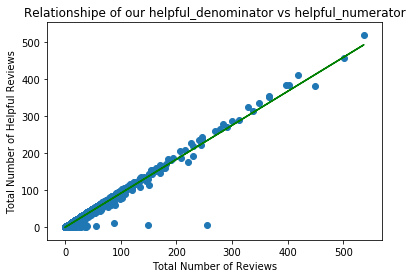

In [554]:
#relationship between total votes and helpful votes
import matplotlib.pyplot as plt
import numpy as np
x_graph1 = df['helpful_denominator']
y_graph1 = df['helpful_numerator']
fig, ax = plt.subplots()
fit = np.polyfit(x_graph1,y_graph1,deg=1)
ax.plot(x_graph1, fit[0] * x_graph1 + fit[1], color = 'green')
ax.scatter(x_graph1,y_graph1)
ax.set_title('Relationshipe of our helpful_denominator vs helpful_numerator')
ax.set_xlabel("Total Number of Reviews")
ax.set_ylabel("Total Number of Helpful Reviews")
plt.show()

We can see a linear relationship between the number of helpful_denominators and helpful_numerators. We lso notice htat the majority of the points lie between 0-200 total number of reviews with the highest density being between 0 and 100. In this project, we focus on using the Random Forest Regressor Model to predict on the number of helpful numerators for each review in our test dataframe.

Our first approach to developing our Random Forest Regressor predictive model is to first develop and engineer features that we can use to train our model. Below is a list of the features we develop and include in our model and a brief description of the purpose for each feature.

'review_first_dif', This function will get the first review time for each item

'rating_mean_dev', This will tell us the rating score deviation from mean

'reviewWords', This will get the number of words of each review text

'summaryWords', This will tell us the mumber of words of each review summary

'ratiosuWord', This will tell us the ratio of summary words to review text words

'reviewSentences', This will tell us the number of sentences of each review text

'summarySentences', This will extract number of sentences of each summary text

'reviewChars', This will tell us the number of characters of each review text

''summaryChars', This will tell us the number of characters of each summary

'reviewRead', This will tell us the readability of each review (ARI as index to measure)

'reviewPuncts', This will tell us the number of punctuations of each review text

'ratiopunChar', This will tell us the ratio of punctuations with characters

'reviewCwords', This will tell us the number of capital words of each review text

'summaryCwords', This will tell us the number of capital words of each summary

'numexclquest', This will tell us the number of exclimation and question marks of each review text

'sunumexclquest', This will tell us the number of exclimation and question marks of each summary text

'numreviewPro', This will tell us the number of reviews of each product (measure the popularity of each product)

'numreviews', This will tell us the number of reviews of each reviewers (measure reviewer’s experience)

'ratiosCWords', This will tell us the ratio of reviewText words to review text words


These features will tell us about the sentiment for the reviewtext and the summary for each review: 'summarypolarity','summarysubjectivity','reviewTextpolarity', 'reviewTextsubjectivity'. 


These features will tell us information on the reviewtext and summary by calculating statistics from text to determine readability, complexity and grade level of a particular corpus: 'reviewTextpolarity', 'reviewTextsubjectivity', 'reviewText_flesch_reading_ease', 'reviewText_smog_index', 'reviewText_coleman_liau_index', 'reviewText_automated_readability_index', 'reviewText_dale_chall_readability_score', 'reviewText_difficult_word', 'reviewText_linsear_write_formula', 'reviewText_gunning_fog', 'reviewText_text_standard', 'summary_flesch_reading_ease', 'summary_smog_index', 'summary_coleman_liau_index', 'summary_automated_readability_index', 'summary_dale_chall_readability_score', 'summary_difficult_word', 'summary_linsear_write_formula', 'summary_gunning_fog', 'summary_text_standard','reviewText_flesch_kincaid_grade','summary_flesch_kincaid_grade','reviewText_text_standartcat', 'summary_text_standartcat'.


'reviewerratingavg', This will tell us the ratio of the average number of the overall ratings.

'itemratingavg', This will tell us the ratio of the average rating number per item in our data set.

'reviewerratingratio', This will tell us the ratio of each rating divided by the average rating overall.

'itemratingratio', This will tell us the ratio for each item of each rating divided bby the average item rating.

'suratioCwords', This tells us a ratio for each summary text of the number of words in the summary text divided by the number of words of the summary words.

'helpful_numerator' (only for our training set), This will tell us the number of helpful reviews for each review.

'helpful_denominator', This will tell us the overall number of reviews.

'helpratio' (only for our training set), This is the ratio of the number of our helpful reviews divided by the overall number of reviews.

'rwavgwords', This is telling us the averageword count by the reviewer

'review_word_length_ratio', This is telling us the ratio of the word length of the review text.

'review_word_mean_by_reviewer', This is telling us the mean of the review text by the reviewer

'summary_word_length_ratio', This is telling us the ratio of the summary word length

'ratDevmean', This is telling us the deviation of the rating from its mean, along with the absolute deviation

'ratDevmean_abs', This is telling us the deviation of the rating from its mean, along with the absolute deviation


We take a look at some of our top features that we include in our final Random Forest Regressor model:

'rating', 
           'price', 
           'helpful_denominator',
           'unixReviewTime',
           'review_first_dif',
           'ratDevmean',
          'reviewRead',  
          'ratiosCWords', 
          'reviewerratingavg', 
          'itemratingavg',  
          'itemratingratio', 
          'summarypolarity', 
          'summarysubjectivity', 
          'reviewerratingratio',
          'reviewWords',
          'summaryWords',
          'ratiosuWord',
          'reviewSentences',
          'summarySentences',
          'reviewChars',
          'summaryChars',
          'reviewText_flesch_reading_ease',
          'reviewText_smog_index',
          'reviewText_flesch_kincaid_grade',
          'reviewText_coleman_liau_index',
          'reviewText_automated_readability_index',
          'reviewText_dale_chall_readability_score',
          'reviewText_difficult_word',
          'reviewText_linsear_write_formula',
          'reviewText_text_standardcat',
          'reviewText_gunning_fog',
          'reviewPuncts',
          'summaryPuncts',
          'ratiopunChar',
          'suratioCwords',
          'summaryratiopunChar',
          'reviewCwords',
          'summaryCwords',
          'numexclquest',
          'sunumexclquest',
          'numreviewPro',
          'numreviews',
          'reviewTextpolarity',
          'reviewTextsubjectivity',
          'rwavgwords',
          'review_word_length_ratio',
          'review_word_mean_by_reviewer',
          'summary_word_length_ratio',
          'summary_automated_readability_index',
          'summary_flesch_reading_ease',
          'summary_smog_index',
          'summary_coleman_liau_index',
          'summary_dale_chall_readability_score',
          'summary_difficult_word',
          'summary_linsear_write_formula',
          'summary_flesch_kincaid_grade'

These features will be filtered on both our train and test dataframes. We then select our model: "Random Forest Regressor" as our method of predicting our ratio to use to get our predicted number of helpful votes.

Before testing our model we have to replace all NaNs, -inf and inf from out train and test dataframes by applying replace([np.inf, -np.inf], np.nan).fillna(0). This is part of the data cleansing process, since our random forest regressor model would error out on NaNs and inf. values.

We set our X and y dataframe for which we will use our train_test_split function will be:

X = df1

y = df[['helpratio','helpful_numerator','helpful_denominator']]

Before we apply our train_test_split function, we split our X and y dataframes into 3 seperate groups. We distinguish the rows that have total number of reviews between 2 and 50, 50 and 100 and one

Here we want to illustrate the correlations between each feature to see which features are high correlated with other features.

In [667]:
X.corr()

,rating,price,helpful_denominator,unixReviewTime,review_first_dif,ratDevmean,reviewRead,ratiosCWords,reviewerratingavg,itemratingavg,...,numexclquest,sunumexclquest,numreviewPro,numreviews,reviewTextpolarity,reviewTextsubjectivity,rwavgwords,review_word_length_ratio,review_word_mean_by_reviewer,summary_word_length_ratio
rating,1.000000,0.025807,-0.032558,-0.032988,0.015930,9.133097e-01,0.045302,0.004354,5.773994e-01,4.072658e-01,...,0.086529,0.102837,3.291079e-03,1.128408e-02,0.425880,0.182651,-4.135441e-02,-0.058035,-7.018838e-02,-0.102549
price,0.025807,1.000000,0.033624,-0.099423,0.054453,-5.399723e-05,0.052526,-0.005296,7.786543e-03,6.348791e-02,...,0.017520,0.006852,-6.324003e-02,-1.292538e-02,-0.012579,-0.017228,9.740853e-02,0.124098,7.678488e-02,0.034867
helpful_denominator,-0.032558,0.033624,1.000000,-0.250942,-0.109646,-2.558131e-02,0.124233,-0.003780,-2.471999e-02,-2.257687e-02,...,0.054257,0.025191,-7.828252e-03,2.738979e-02,-0.055445,-0.033040,2.039961e-01,0.249519,1.073647e-01,0.060557
unixReviewTime,-0.032988,-0.099423,-0.250942,1.000000,0.163691,-1.710617e-02,-0.084432,0.006442,-3.258445e-02,-4.263644e-02,...,-0.046389,-0.033968,3.929008e-02,-2.379321e-02,0.020989,0.016411,-1.956081e-01,-0.170878,-3.745383e-02,-0.020204
review_first_dif,0.015930,0.054453,-0.109646,0.163691,1.000000,-1.079304e-02,-0.016592,-0.006418,1.214580e-02,6.331813e-02,...,-0.029510,-0.028204,2.930456e-01,-3.350752e-02,-0.004617,-0.031959,-2.586619e-02,-0.024390,-1.375462e-02,0.018198
ratDevmean,0.913310,-0.000054,-0.025581,-0.017106,-0.010793,1.000000e+00,0.037032,0.009592,5.269991e-01,-1.914499e-16,...,0.081619,0.094818,-1.558680e-16,2.274015e-02,0.384352,0.165310,-5.169335e-02,-0.059612,-5.704781e-02,-0.099126
reviewRead,0.045302,0.052526,0.124233,-0.084432,-0.016592,3.703162e-02,1.000000,-0.015278,1.556791e-02,2.818984e-02,...,0.212505,0.288811,2.507729e-04,3.466070e-03,-0.052898,-0.037929,3.593954e-01,0.484821,2.340609e-01,0.147066
ratiosCWords,0.004354,-0.005296,-0.003780,0.006442,-0.006418,9.591749e-03,-0.015278,1.000000,1.388704e-02,-1.081948e-02,...,0.053673,0.039114,5.645041e-03,8.540715e-03,0.014570,-0.010859,-3.399706e-02,-0.014765,2.694308e-02,-0.008304
reviewerratingavg,0.577399,0.007787,-0.024720,-0.032584,0.012146,5.269991e-01,0.015568,0.013887,1.000000e+00,2.359294e-01,...,0.052849,0.062255,-7.944478e-03,1.954294e-02,0.269538,0.118634,-7.162184e-02,-0.054174,1.678785e-18,-0.069342
itemratingavg,0.407266,0.063488,-0.022577,-0.042636,0.063318,-1.914499e-16,0.028190,-0.010819,2.359294e-01,1.000000e+00,...,0.029431,0.039873,8.080912e-03,-2.328876e-02,0.183781,0.077769,1.438283e-02,-0.008817,-4.440850e-02,-0.029504


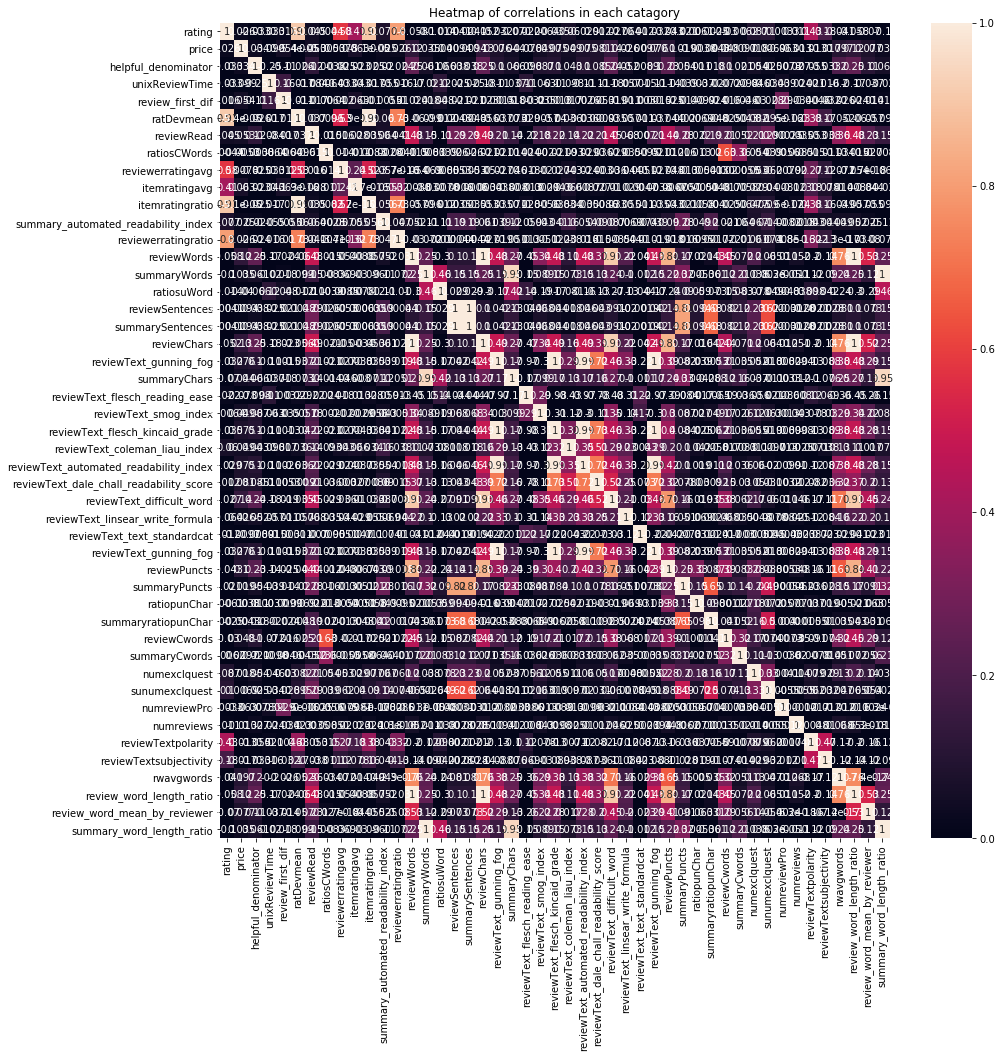

In [668]:
correlations = X.corr()
plt.figure(figsize = (15,15))
plt.title("Heatmap of correlations in each catagory")
_ = sns.heatmap(correlations, vmin=0, vmax=1, annot=True)

We notice that there are some features that have high correlations with other features (those with brighter colors). The correlations heat map can also tell us which features will add of more importance to our model.

The code below is an excerpt of our training model that uses Random Forest Regressor on all the rows of our training set where we have total number of reviews greater than 0. This is the format we use to train our model and to predict on our validation set. We use train_test_split for this grouping with test_size = .2. We call this test group our validation group. After we fit our model, we retrain our model with the entire group which includes the train and validation group in order to have a better model for our test predictions. We decide to use a random forest regerssor as our model with 88 number of estimators because, a random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. A Random Forest is an ensemble technique capable of performing both regression and classification tasks with the use of multiple decision trees and a technique called Bootstrap Aggregation, commonly known as bagging, where bagging, in the Random Forest method, involves training each decision tree on a different data sample where sampling is done with replacement. The basic idea behind this is to combine multiple decision trees in determining the final output rather than relying on individual decision trees. It operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. A random forest is a meta-estimator (i.e. it combines the result of multiple predictions) which aggregates many decision trees, with some helpful modifications:
The number of features that can be split on at each node is limited to some percentage of the total (which is known as the hyperparameter). This ensures that the ensemble model does not rely too heavily on any individual feature, and makes fair use of all potentially predictive features.
Each tree draws a random sample from the original data set when generating its splits, adding a further element of randomness that prevents overfitting.




### This is the beginning of the code for this group of our Random Forest Regressor Modeling.

X_0 = X[X['helpful_denominator']>1]


y_0 = y[y['helpful_denominator']>1]


X_train0, X_val0, y_train0, y_val0 = train_test_split(X_0,y_0, test_size=0.2, random_state=42)

y_trainadj0 = y_train0['helpratio']
clf0 = RandomForestRegressor(bootstrap=True,
                           criterion='mse',
                           max_depth=None,
                           max_features='auto',
                           max_leaf_nodes=None,
                           #max_samples=None,
                           min_impurity_decrease=0.0,
                           min_impurity_split=None,
                           min_samples_leaf=1,
                           min_samples_split=2,
                           min_weight_fraction_leaf=0.0,
                           n_estimators=88,
                           n_jobs=None,
                           oob_score=False,random_state=42,
                           verbose=0,
                           warm_start=False)

clf0.fit(X_train0, y_trainadj0)
y_val_pred0 = clf0.predict(X_val0)
mean_absolute_error(y_val0['helpful_numerator'],np.round((X_val0['helpful_denominator']*y_val_pred0),0))


X_train_valid0 = X_0
y_train_valid0 = y_0['helpratio']
clf0.fit(X_train_valid0,y_train_valid0)
y_val_pred0 = clf0.predict(X_val0)
mean_absolute_error(y_val0['helpful_numerator'],np.round((X_val0['helpful_denominator']*y_val_pred0),0))

### Optional: This set of code can look at our current final list of features and tell you which features would be considered the most important for our model.

sel = SelectFromModel(RandomForestRegressor(bootstrap=True,
                           criterion='mse',
                           max_depth=None,
                           max_features='auto',
                           max_leaf_nodes=None,
                           #max_samples=None,
                           min_impurity_decrease=0.0,
                           min_impurity_split=None,
                           min_samples_leaf=1,
                           min_samples_split=2,
                           min_weight_fraction_leaf=0.0,
                           n_estimators=87,
                           n_jobs=None,
                           oob_score=False,random_state=42,
                           verbose=0,
                           warm_start=False))
sel.fit(X_trainadj, y_trainadj)
sel.get_support()
selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)
print(selected_feat)

In my approach, I try to obtain the lowest Mean Absolute Error (MAE) for all of the 3 groups against the validation sets. Mean Absolute Error of your model refers to the mean of the absolute values of each prediction error on all instances of the test data-set. Prediction error is the difference between the actual value and the predicted value for that instance. This was of course done by adding and removing features when hypertuning. I would get around .16-.17 in my MAEs against the validation sets.

Once we train and retrain our models for each grouping, we get our final probabilities for each prediction from each group and we append these probabilities to our final test dataframe. 

y_test_pred0 = clf0.predict(test_df1)

y_test_pred50 = clf50.predict(test_df1)

y_test_pred100 = clf100.predict(test_df1)

#y_test_pred200 = clf200.predict(test_df1)

test_df['votingprob0'] = y_test_pred0

test_df['votingprob50'] = y_test_pred50

test_df['votingprob100'] = y_test_pred100


Once this step is completed, it becomes time to get our final prediction for the number of helpful reviews. This for loop looks at each row, and based on the number of the helpful denominator reviews, it will predict the final number by multiplying that helpful denominator times the probability we get from the specific group it lies in. So if the row has 45 number of reviews, we search in our 'votingprob50' column for the probability and multiply that probability by 45 to get our final number of helpful reviews.

"counter_test = 0

prediction_values = []

for i in test_df['helpful_denominator']:

    if i == 0:
    
        prediction_values.append(0)
        
    elif i == 1:
    
        if test_df.loc[counter_test,['rating']].item() >=3:
        
            prediction_values.append(1)
            
        else:
        
            prediction_values.append(0)
            
    elif i == 2:
    
        if test_df.loc[counter_test,['rating']].item() >=3:
        
            prediction_values.append(2)
            
        else:
        
            prediction_values.append(int(round(i*test_df.loc[counter_test,'votingprob50'],0)))
            
    elif test_df.loc[counter_test,['helpful_denominator']].item() > 100:
    
        prediction_values.append(int(round(i*test_df.loc[counter_test,'votingprob0'],0)))
        
    elif 100 >= test_df.loc[counter_test,['helpful_denominator']].item() > 50:
    
        prediction_values.append(int(round(i*test_df.loc[counter_test,'votingprob100'],0)))
        
    else:
    
        prediction_values.append(int(round(i*test_df.loc[counter_test,'votingprob50'],0)))
        
    counter_test += 1
    
prediction_values"

Once this code is finished running, we double check to make sure we have 14000 values in our column and then we append these final values to our test dataframe.

Once this has been completed, we then run our last set of code to create a text file with our final predictions and finish the job!

"counter = 0
predictions = open("predictions_Helpful_testdf.txt", 'w')
for l in open("pairs_Helpful.txt"):
  if l.startswith("userID"):
    #header
    predictions.write(l)
    continue
  u,i,outOf = l.strip().split('-')
  outOf = int(outOf)
  #for pred in b:
  predictions.write(u + '-' + i + '-' + str(outOf) + ',' + str(test_df.loc[counter,'predictions']) + '\n')
  counter +=1
  #else:
  #predictions.write(u + '-' + i + '-' + str(outOf) + ',' + str(outOf*averageRate) + '\n')
predictions.close()"


We then submit this file to Kaggle and upload!